In [ ]:
!git clone https://github.com/MarianaGuez/Parsimony

Cloning into 'Parsimony'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 113 (delta 14), reused 106 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (113/113), 5.53 MiB | 15.26 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
!pip install dill

In [ ]:
!pip install umap-learn
import umap.umap_ as umap
reducer = umap.UMAP()

In [ ]:
import os
import umap.umap_ as umap
import torch

In [ ]:
!cd /content/Parsimony/hybparsimony
os.chdir("/content/Parsimony/hybparsimony")

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
"""
We used a modified version of the hybparsimony genetic algorithm [1] for feature selection.
The original algorithm was extended by replacing the default fitness evaluation with a custom fitness function tailored to our task.
No hyperparameter optimization was performed; the genetic search operated solely on feature subsets.
The parsimony mechanism controlled by the parameter γ was preserved.
All other evolutionary operators followed the original implementation.
[1] Jodrá, P., & Díaz, J. (2021). hybparsimony: A hybrid parsimony-based genetic algorithm for feature selection. GitHub repository.
"""

import copy
import multiprocessing
import random
from multiprocessing import Pool
from functools import partial
from hybparsimony.util import Population, order, getFitness, parsimony_monitor, parsimony_summary, models
from hybparsimony.util.fitness import fitness_for_parallel
from hybparsimony.util.hyb_aux import _rerank, _crossover, _population
from hybparsimony.lhs import randomLHS
import math
import numpy as np
import pandas as pd
import time
import dill
from numpy.random import multinomial
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from hybparsimony.util.models import check_algorithm
# HYBparsimony(features=names, custom_eval_fun = custom_eval_fun, early_stop=40, n_jobs=10, rerank_error=0.001, verbose=1)
class HYBparsimony(object):

    def __init__(self,
                 fitness = None,
                 features = None,
                 algorithm = None,
                 custom_eval_fun = None,
                 cv = None,
                 scoring = None,
                 type_ini_pop = "improvedLHS",
                 npart = 15,
                 maxiter = 250,
                 early_stop = None,
                 Lambda = 1.0,
                 c1 = 1/2 + math.log(2),
                 c2 = 1/2 + math.log(2),
                 IW_max = 0.9,
                 IW_min = 0.4,
                 K = 3,
                 pmutation = 0.1,
                 gamma_crossover = 0.5,
                 tol = 1,
                 rerank_error = 1e-09,
                 keep_history = False,
                 feat_thres = 0.90,
                 best_global_thres = 1,
                 particles_to_delete = None,
                 seed_ini = 1234,
                 not_muted = 3,
                 feat_mut_thres = 0.1,
                 n_jobs = 5,
                 verbose = 0):
        r"""
            A class for searching parsimonious models by feature selection and parameter tuning with
            an hybrid method based on genetic algorithms and particle swarm optimization.

            Parameters
            ----------

            ########################## CHROMOSOME WITH FEATURES ########################### PULPETA - MODIFICAR EL TOMAR PARAMETROS PARA EL MODELO
            fitness : function, optional
                The fitness function, any function which takes as input a chromosome which combines the model parameters
                to tune and the features to be selected. Fitness function returns a numerical vector with three values: validation_cost,
                testing_cost and model_complexity, and the trained model.
            ##################################################################################


            ############################## NAMES OF FEATURES ###############################
            features : list of str, default=None
                The name of features/columns in the dataset. If None, it extracts the names if X is a dataframe, otherwise it generates a list of the positions according to the value of X.shape[1].
            ##################################################################################


            ############################ ALGORITHM TO OPTIMIZE ############################# NO CONTEMPLAR
            algorithm: string or dict, default=None
                Id string, the name of the algorithm to optimize (defined in 'hybparsimony.util.models.py') or a dictionary defined
                with the following properties: {'estimator': any machine learning algorithm compatible with scikit-learn,
                'complexity': the function that measures the complexity of the model, 'the hyperparameters of the algorithm':
                in this case, they can be fixed values (defined by Population.CONSTANT) or a search range $[min, max]$
                defined by {"range":(min, max), "type": Population.X} and which type can be of three values:
                integer (Population.INTEGER), float (Population.FLOAT) or in powers of 10 (Population.POWER),
                i.e. $10^{[min, max]}$}. If algorithm==None, hybparsimony uses 'LogisticRegression()' for
                classification problems, and 'Ridge' for regression problems.
            ##################################################################################


            ############################## CROSS-VALIDATION ################################## -MY FORMULA AS AN EVALUATION FUNCTION-

            custom_eval_fun : function, default=None                                            -USING THIS VARIABLE THE NEW SCORING VARIABLE IS GIVEN BY THE USER
                An evaluation function similar to scikit-learns's 'cross_val_score()'. If None, hybparsimony uses
                'cross_val_score(cv=5)'.
            cv: int, cross-validation generator or an iterable, default=None                    -IS NOT A BAD IDEA TO MAKE A CROSS VALIDATION ON THE DATA / SEPARATION OF DATA INTO TRAINING, VALIDATION AND TEST
                Determines the cross-validation splitting strategy (see scikit-learn's 'cross_val_score()' function)

            scoring: str, callable, list, tuple, or dict, default=None.                         -OUR GOAL IS TO MAKE UNUSED THIS VARIABLE
                Strategy to evaluate the performance of the cross-validated model on the test set. If None cv=5 and 'scoring' is defined as MSE for regression problems,
                'log_loss' for binary classification problems, and 'f1_macro' for multiclass problems. (see scikit-learn's
                'cross_val_score()' function)

            n_jobs : int, default=5,                                                            - UNRELEVANT
                Number of cores to include in 'n_jobs' of cross_val_score() included in 'default_cv_score()' function. Default is set to 5 (cv=5 folds).
                Note: It is important to note that some sklearn algorithms also perform parallelization by default.
            ##################################################################################


            ############################### STOP VARIABLES ###################################
            maxiter = int, default=250
                The maximum number of iterations to run before the HYB process is halted.
            early_stop : int, optional
                The number of consecutive generations without any improvement lower than a difference of 'tol'
                in the 'best_fitness' value before the search process is stopped.
            tol : float, default=1e-09,
                Value defining a significant difference between the 'best_fitness' values between iterations for 'early stopping'.
            ##################################################################################


            ################################ MODEL RANKING ##################################
            rerank_error : float, default=1e-09
                When a value is provided, a second reranking process according to the model complexities is called by `parsimony_rerank` function.
                Its primary objective is to select individuals with high validation cost while maintaining the robustness of a parsimonious model.
                This function switches the position of two models if the first one is more complex than the latter and no significant difference
                is found between their fitness values in terms of cost. Thus, if the absolute difference between the validation costs are
                lower than `rerank_error` they are considered similar.
            ##################################################################################

            ##################################    PSO     #####################################
            ################################# POPULATION ######################################
            type_ini_pop : str, {'randomLHS', 'geneticLHS', 'improvedLHS', 'maximinLHS', 'optimumLHS', 'random'}, optional
                Method to create the first population with `GAparsimony._population` function. Possible values: `randomLHS`, `geneticLHS`,
                `improvedLHS`, `maximinLHS`, `optimumLHS`, `random`. First 5 methods correspond with several latine hypercube for initial sampling. By default is set to `improvedLHS`.
            npart = int, default=15
                Number of particles in the swarm (population size)

            ################################# REPLACESMENT #####################################
            gamma_crossover : float, default=0.50
                In hybparsimony, the percentage of variables to be replaced with GA at each iteration $t$ is selected by a decreasing exponential function
                that is adjusted by a 'gamma_crossover' parameter (see references for more info).
            Lambda : float, default=1.0
                PSO parameter (see References)
            c1 : float, default=1/2 + math.log(2)
                PSO parameter (see References)
            c2 : float, default=1/2 + math.log(2)
                PSO parameter (see References)
            IW_max : float, default=0.9
                PSO parameter (see References)
            IW_min : float, default=0.4
                PSO parameter (see References)
            K : int, default=4
                PSO parameter (see References)
            best_global_thres : float, default=1.0
                Percentage of particles that will be influenced by the best global of their neighbourhoods
                (otherwise, they will be influenced by the best of the iteration in each neighbourhood)
                particles_to_delete is not None and len(particles_to_delete) < maxiter:
            particles_to_delete : float, default=None
                The length of the particles to delete is lower than the iterations,
                the array is completed with zeros up to the number of iterations.
            mutation : float, default=0.1
                The probability of mutation in a parent chromosome. Usually mutation occurs with a small probability. By default is set to `0.10`.
            feat_mut_thres : float, default=0.1
                Probability of the muted `features-chromosome` to be one. Default value is set to `0.10`.
            feat_thres : float, default=0.90
                Proportion of selected features in the initial population. It is recommended a high percentage of the selected features for
                the first generations.
            keep_history : bool default=False,
                If True keep results of all particles in each iteration into 'history' attribute.
            seed_ini : int, optional
                An integer value containing the random number generator state.
            ##################################################################################


            ##################################### MESSAGES ######################################
            verbose : int, default=0
                The level of messages that we want it to show us. Possible values: 0=silent mode, 1=monitor level,  2=debug level.
            #####################################################################################


        Attributes
        ----------
        minutes_total : float
            Total elapsed time (in minutes).
        history : float
            A list with the results of the population of all iterations.'history[iter]' returns a DataFrame
            with the results of iteration 'iter'.
        best_model
            The best model in the whole optimization process.
        best_score : float
            The validation score of the best model.
        best_complexity : float
            The complexity of the best model.
        selected_features : list,
            The name of the selected features for the best model.
        selected_features_bool : list,
           The selected features for the best model in Boolean form.
        best_model_conf : Chromosome
            The parameters and features of the best model in the whole optimization process.
        """

        self.type_ini_pop = type_ini_pop
        self.fitness = fitness
        self.features = features
        self.npart = npart
        self.maxiter = maxiter
        self.early_stop = maxiter if not early_stop else early_stop
        self.Lambda = Lambda
        self.c1 = c1
        self.c2 = c2
        self.IW_max = IW_max
        self.IW_min = IW_min
        self.K = K
        self.tol = tol
        self.rerank_error = rerank_error
        self.verbose = verbose
        self.seed_ini = seed_ini

        if pmutation is None:
            self.pmutation = 0.0
        else:
            self.pmutation = pmutation
        self.not_muted = not_muted
        self.feat_mut_thres = feat_mut_thres

        self.feat_thres = feat_thres

        self.minutes_total = 0
        self.history = list()
        self.keep_history = keep_history

        # Percentage of particles that will be influenced by the best global of their neighbourhoods
        self.best_global_thres = best_global_thres

        self.pcrossover = None
        if gamma_crossover != 0.0:
            perc_malos = 0.80 * np.exp(-gamma_crossover * np.arange(self.maxiter))
            perc_malos[perc_malos < 0.10] = 0.10
            self.pcrossover = perc_malos

        self.n_jobs=n_jobs

        # if self.n_jobs < 1:
        #     self.n_jobs = multiprocessing.cpu_count()  # Si ponemos un -1, entonces todos los cores (aunque la validación cruzada ya hará más aún!).

        if particles_to_delete is not None and len(particles_to_delete) < maxiter:
            # If the length of the particles to delete is lower than the iterations, the array is completed with zeros
            # up to the number of iterations.
            self.particles_to_delete = np.zeros(maxiter).astype(int)
            self.particles_to_delete[:len(particles_to_delete)] = particles_to_delete[:]
        else:
            self.particles_to_delete = particles_to_delete

        if self.seed_ini:
            np.random.seed(self.seed_ini)

        # Custom cross val score
        self.custom_eval_fun = custom_eval_fun

        self._cv=cv
        self._scoring=scoring
        self.algorithm = algorithm


    def fit(self, X, y, image_name_to_save, time_limit=None):
        r"""
        Performs the search of accurate parsimonious models by combining feature selection, hyperparameter optimizacion,
            and parsimonious model selection (PMS) with data matrix (X) and targets (y).

        Parameters
        ----------
        X : pandas.DataFrame or numpy.array
            Training vector.
        y : pandas.DataFrame or numpy.array
            Target vector relative to X.
        time_limit : float, default=None
            Maximum time to perform the optimization process in minutes.
        """

        #  SOME LOGIC ON PARAMETERS' INITIALIZATION

        #############################################
        # - IF *VERBOSE* IS 0 THIS IS NOT HAPPENING -
         #############################################

        # Check if 'custom_eval_fun' and 'fitness' are not none
        if self.verbose > 0 and self.custom_eval_fun!=None and self.fitness!=None:
            print("The two parameters 'fitness' and 'custom_eval_fun' have been defined by the user. 'custom_eval_fun' is only used within the 'fitness' function that exists by default. Thus, the user-defined 'custom_eval_fun' function will not be used.")

        # Check if 'custom_eval_fun' and 'cv' are not none
        if self.verbose > 0 and self.custom_eval_fun!=None and self._cv!=None:
            print("The two parameters 'custom_eval_fun' and 'cv' have been defined by the user. 'cv' is only used within the 'custom_eval_fun' function that exists by default. Thus, the user-defined 'cv' function will not be used.")

        # Check if 'custom_eval_fun' and 'scoring' are not none
        if self.verbose > 0 and self.custom_eval_fun!=None and self._scoring!=None:
            print("The two parameters 'custom_eval_fun' and 'scoring' have been defined by the user. 'scoring' is only used within the 'custom_eval_fun' function that exists by default. Thus, the user-defined 'scoring' function will not be used.")

        ####################################################
        # - IF *SCORING* IS DEFINED THIS IS NOT HAPPENING -
        ####################################################

        # Detect the kind of problem and define the default 'scoring' function.
        def check_classification(y):
           return np.issubdtype(y.dtype, np.integer)

        if self._scoring is not None:
            default_scoring = self._scoring  #  - THE DEFAULT SCORING IS NOW THE USER SCORING -
            if self.verbose > 0 and self.custom_eval_fun==None and self.fitness==None:
                print(f"Using '{default_scoring}' as scoring function.")
        elif check_classification(y):
            if len(np.unique(y))==2:
                default_scoring = 'neg_log_loss'
                if self.verbose > 0 and self.custom_eval_fun==None and self.fitness==None:
                    print("Detected a binary-class problem. Using 'neg_log_loss' as default scoring function.")
            else:
                default_scoring = 'f1_macro'
                if self.verbose > 0 and self.custom_eval_fun==None and self.fitness==None:
                    print("Detected a multi-class problem. Using 'f1_macro' as default scoring function.")
        else:
            default_scoring = 'neg_mean_squared_error'
            if self.verbose > 0 and self.custom_eval_fun==None and self.fitness==None:
                print("Detected a regression problem. Using 'neg_mean_squared_error' as default scoring function.")

        def default_cv_score(estimator, X, y):
            return cross_val_score(estimator, X, y, cv=5, scoring=default_scoring, n_jobs=self.n_jobs)

        ###########################################################
        # - IF *CUSTOM_EVAL_FUN* IS DEFINED THIS IS NOT HAPPENING -
        ###########################################################

        # Create 'custom_eval_fun' is not defined
        if self._cv is not None and self.custom_eval_fun is None:
            if self._scoring is not None:
                self.custom_eval_fun = partial(cross_val_score, cv=self._cv, scoring=self._scoring, n_jobs=self.n_jobs)
            else: # Por defecto:
                self.custom_eval_fun = partial(cross_val_score, cv=self._cv, scoring=default_scoring, n_jobs=self.n_jobs)
        elif self.custom_eval_fun is None:
            if self._scoring is not None:
                self.custom_eval_fun = partial(cross_val_score, scoring=self._scoring, n_jobs=self.n_jobs)
            else:
                self.custom_eval_fun = default_cv_score

        # PAST CODE HERE
        # Select and check 'algorithm' from dictionary
        self.algorithm = check_algorithm(self.algorithm, check_classification(y))
        self.params = {k: self.algorithm[k] for k in self.algorithm.keys() if k not in ["estimator", "complexity"]}

        # Create 'fitness' is not defined
        if self.fitness is None:
            # Fitness function
            self.fitness = getFitness(self.features, self.algorithm['estimator'], self.algorithm['complexity'],
                                        self.custom_eval_fun)

        # Get colnames o create numeric names if features names are not defined
        if self.features is None:
            if "pandas" in str(type(X)):
                self.features = X.columns
            else:
                num_rows, num_cols = X.shape
                self.features = list(range(num_cols))

        #############################################
        #               THE HYBRID METHOD
        #############################################

        start_time = time.time()

        if self.seed_ini:
            np.random.seed(self.seed_ini)

        population = Population(self.params, columns=self.features)
        population.population = _population(population, seed_ini=self.seed_ini, popSize=self.npart,
                                            type_ini_pop=self.type_ini_pop)  # To create the initial population


        # Update population to satisfy the feat_thres
        population.update_to_feat_thres(self.npart, self.feat_thres)

        nfs = len(population.colsnames)
        nparams = len(population._params)
        self._summary = np.empty((self.maxiter, 6 * 2,))
        self._summary[:] = np.nan
        self.best_score = -np.inf
        self.best_complexity = np.inf


        maxFitness = np.inf
        best_fit_particle = np.empty(self.npart)
        best_fit_particle[:] = -np.inf

        best_pos_particle = np.empty(shape=(self.npart, nparams + nfs))
        best_complexity_particle = np.empty(self.npart)  # Complexities
        best_complexity_particle[:] = np.inf

        range_numbers = population._max - population._min
        vmax = self.Lambda * range_numbers
        range_as_pd = pd.Series(range_numbers)
        lower_as_pd = pd.Series(population._min)
        v_norm = randomLHS(self.npart, nparams + nfs)
        v_norm = pd.DataFrame(v_norm)
        v_norm = v_norm.apply(lambda row: row * range_as_pd, axis=1)
        v_norm = v_norm.apply(lambda row: row + lower_as_pd, axis=1)

        velocity = (v_norm - population._pop) / 2
        velocity = velocity.to_numpy()

        self.bestSolList = list()
        self.best_models_list = list()
        self.best_models_conf_list = list()

        # Variables to store the best global positions, fitnessval and complexity of each particle
        bestGlobalPopulation = copy.deepcopy(population._pop)
        bestGlobalFitnessVal = np.empty(self.npart)
        bestGlobalFitnessVal[:] = -np.inf
        bestGlobalComplexity = np.empty(self.npart)
        bestGlobalComplexity[:] = np.inf

        # Variable that tracks the deleted particles (their number in the table)
        deleted_particles = []
        valid_particles = [x for x in range(self.npart) if
                           x not in deleted_particles]  # valid particles (numbers in the table)

        fitnessval = np.empty(self.npart)
        fitnessval[:] = np.nan
        fitnesstst = np.empty(self.npart)
        fitnesstst[:] = np.nan
        complexity = np.empty(self.npart)
        complexity[:] = np.nan
        _models = np.empty(self.npart).astype(object)
        _models[:] = None
        my_plots = np.empty(self.npart).astype(object)
        my_plots[:] = None
        chromosomes = np.empty(self.npart).astype(object)
        chromosomes[:] = None

        image_to_save_i = 0
        update_neighbourhoods = False
        crossover_applied = False
        My_aux = -1
        My_bestComplexity = 1000
        for iter in range(self.maxiter):
            if self.verbose > 0:
                print("Running iteration", iter)

            tic = time.time()

            #####################################################
            # Compute solutions
            #####################################################
            time_out = False
            for t in valid_particles:
                c = population.getChromosome(t)
                if np.sum(c.columns) > 0:
                    fit = self.fitness(c, X=X, y=y)
                    fitnessval[t] = fit[0][0]
                    complexity[t] = fit[0][1]
                    _models[t] = fit[1]
                    my_plots[t] = fit[2]
                    chromosomes[t] = c

        #
                if time_limit is not None and time_limit < (time.time() - start_time)/60:
                    time_out = True
                    break

            if time_out:
                if self.verbose > 0:
                    print("Time limit reached. Stopped.")
                break

            if self.seed_ini:
                np.random.seed(self.seed_ini * iter)

            # Sort by the Fitness Value
            # ----------------------------
            sort = order(fitnessval, kind='heapsort', decreasing=True, na_last=True)
            PopSorted = population[sort, :].copy()
            FitnessValSorted = fitnessval[sort]
            ComplexitySorted = complexity[sort]
            _modelsSorted = _models[sort]
            my_plot = my_plots[sort]
            chromosome = chromosomes[sort]
            #variables_selected = population.getChromosome(sort)

            if self.verbose == 2:
                print("\nStep 1. Fitness sorted")
                print(np.c_[FitnessValSorted, ComplexitySorted, population.population][:10, :])
                # input("Press [enter] to continue")

            if self.rerank_error != 0.0:
                ord_rerank = _rerank(FitnessValSorted, ComplexitySorted, self.npart, self.rerank_error)
                PopSorted = PopSorted[ord_rerank]
                FitnessValSorted = FitnessValSorted[ord_rerank]
                ComplexitySorted = ComplexitySorted[ord_rerank]
                _modelsSorted = _modelsSorted[ord_rerank]
                plotSorted = my_plot[ord_rerank]
                chromosomeSorted = chromosome[ord_rerank]
                #variables_selected = PopSorted.getChromosome(0)

                if self.verbose == 2:
                    print("\nStep 2. Fitness reranked")
                    print(np.c_[FitnessValSorted, ComplexitySorted, population.population][:10, :])

            # Keep results
            # ---------------
            self._summary[iter, :] = parsimony_summary(FitnessValSorted, ComplexitySorted)

            # Keep Best Solution of this iteration
            # ------------------
            bestfitnessVal = FitnessValSorted[0]
            bestcomplexity = ComplexitySorted[0]
            bestIterSolution = np.concatenate([[bestfitnessVal, bestcomplexity], PopSorted[0]])
            self.bestSolList.append(bestIterSolution)
            self.best_models_list.append(_modelsSorted[0])
            self.best_models_conf_list.append(PopSorted[0])


            # Keep Global Best Model #AQUI CAMBIASTE UN AND
            # ------------------
            # The best_score of the whole process. It is update if we find a better AQUI   score, or equal but with lower complexity.
            #if bestfitnessVal > self.best_score or (bestfitnessVal == self.best_score and bestcomplexity < self.best_complexity):
            if bestfitnessVal > self.best_score or (bestfitnessVal == self.best_score and bestcomplexity < self.best_complexity):
                self.best_score = bestfitnessVal
                self.best_complexity = bestcomplexity
                self.bestsolution = bestIterSolution
                self.solution_best_score = np.r_[self.best_score, bestfitnessVal, bestcomplexity]
                self.best_model = _modelsSorted[0]
                self.best_model_conf = PopSorted[0].copy()




            # Update global best positions, fitness and complexity of each particle (with NO rerank)
            for i in range(self.npart):
                if fitnessval[i] > bestGlobalFitnessVal[i] or (fitnessval[i] == bestGlobalFitnessVal[i] and complexity[i] < bestGlobalComplexity[i]):
                    bestGlobalPopulation[i,:] = population._pop[i,:]
                    bestGlobalFitnessVal[i] = fitnessval[i]
                    bestGlobalComplexity[i] = complexity[i]


            # Keep elapsed time in minutes
            # ----------------------------
            tac = time.time()
            elapsed_gen = (tac - tic) / 60.0
            self.minutes_total += + elapsed_gen

            # Keep this generation into the History list (with no order)
            # ------------------------------------------
            if self.keep_history:
                self.history.append(
                    pd.DataFrame(np.c_[population.population, fitnessval, fitnesstst, complexity],
                                 columns=list(population._params.keys()) + population.colsnames + ["fitnessval", "fitnesstst",
                                                                                                   "complexity"]))


            # Call to 'monitor' function
            # --------------------------
            if self.verbose > 0:
                parsimony_monitor(iter, self.best_score, self.best_complexity, fitnessval, bestfitnessVal, bestcomplexity, elapsed_gen)

                if bestfitnessVal == self.best_score and bestcomplexity == self.best_complexity:
                  #print(f'best_model_conf: {self.best_model_conf}')
                  indices = chromosomeSorted[0].columns
                  array_caracteristicas = np.array(self.features) ##Added by Mariana
                  #print(f'array_caracteristicas: {array_caracteristicas[indices]}')
                  #image_to_save_i+=1
                  #plot2d([plotSorted[0],y], image_to_save_i, image_name_to_save)



            if self.verbose == 2:
                print("\nStep 3. Fitness results")
                print(np.c_[FitnessValSorted, ComplexitySorted, population.population][:10, :])

            best_val_cost = self._summary[:, 0][~np.isnan(self._summary[:, 0])]
            if bestfitnessVal >= maxFitness:
                break
            if iter == self.maxiter:
                break

            if (len(best_val_cost) - (np.min(np.arange(len(best_val_cost))[best_val_cost >= (np.max(best_val_cost) - self.tol)]))) >= self.early_stop:
                if self.verbose > 0:
                    print("Early stopping reached. Stopped.")
                break
            # if time_limit is not None and time_limit < (time.time() - start_time)/60:
            #     if self.verbose > 0:
            #         print("Time limit reached. Stopped.")
            #     break

            ####################################################
            # Deletion step (disabled by default)
            ####################################################
            if self.particles_to_delete is not None and self.particles_to_delete[iter]>0:
                # particles_to_delete[iter] contains the number of particles to be deleted in that iteration
                # We delete the worse particles at that point (in global, not in that iteration).
                sort1 = order(bestGlobalFitnessVal, kind='heapsort', decreasing=True, na_last=True)
                sort_not_deleted = [x for x in sort1 if x not in deleted_particles]
                deleted_particles = deleted_particles + sort_not_deleted[-self.particles_to_delete[iter]:]
                valid_particles = [x for x in range(self.npart) if x not in deleted_particles]
                update_neighbourhoods = True




            #####################################################
            # Generation of the Neighbourhoods
            #####################################################
            # If there is no improvement in the current iteration, the neighbourhood is changed. It also changes if particles have been deleted.
            if FitnessValSorted[0] <= self.best_score or update_neighbourhoods:
                update_neighbourhoods = False
                nb = list()
                for i in range(self.npart):
                    # Each particle informs at random K particles (the same particle may be chosen several times), and informs itself.
                    # The parameter K is usually set to 3. It means that each particle informs at less one particle (itself), and at most K+1 particles (including itself)

                    # Thus, a random integer vector of K elements between 0 and npart-1 is created and we append the particle.
                    # Duplicates are removed and this represents the neighbourhood.
                    if i not in deleted_particles:
                        #nb.append(np.unique(np.append(np.random.randint(low=0, high=self.npart - 1, size=self.K), i)))

                        indices = np.random.randint(low=0, high=len(valid_particles), size=self.K) # High is not included
                        random_particles = [valid_particles[index] for index in indices]
                        nb.append(np.unique(np.append(random_particles, i)))
                    else:
                        nb.append(np.nan)

                # Create an array to decide if a particle must be influenced by the best global of the neighbourhoods or the best of the iteration
                nb_global = np.random.choice(a=[True, False], size=(self.npart,), p=[self.best_global_thres, 1-self.best_global_thres])



            ###########################################
            # Update particular global bests (best position of the particle in the whole process, wrt to rerank)
            ###########################################

            # We have to take care to avoid problems with rerank:
            # EXAMPLE (rerank = 0.08):
            # SCORE 0.80 0.85 0.90
            # COST    10  100  200
            # The best score wrt to rerank should be 0.85. But if we get 0.80 with cost 10 in the next
            # iteration, that would be chosen. This is wrong, since we would be moving to worse scores. The
            # rerank must be applied wrt the best global score of each particle.
            for t in [p for p in range(self.npart) if np.isfinite(fitnessval[p])]:# Solo cogemos las partículas que tienen fitnessval finito (que no sea Nan ni inf)
                # Three cases:
                # (1) If the best improves much, then update.
                # (2) If the best does not improve much, but the complexity is lower, then update.
                # (3) Otherwise, rerank criterion, but "consuming the rerank" wrt to the global best.
                if (fitnessval[t] > best_fit_particle[t] + self.rerank_error) \
                    or (fitnessval[t] >= best_fit_particle[t] and complexity[t] < best_complexity_particle[t]) \
                    or (best_fit_particle[t] - fitnessval[t]) <= self.rerank_error - (bestGlobalFitnessVal[t] - best_fit_particle[t]) and complexity[t] < best_complexity_particle[t]:
                    best_fit_particle[t] = fitnessval[t]  # Update the particular best fit of that particle.
                    best_pos_particle[t, :] = population._pop[t, :]  # Update the particular best pos of that particle.
                    best_complexity_particle[t] = complexity[t] # Update the complexity (could be more complex if the fitnessval[t] is better)

            ###########################################
            # Compute Local bests in the Neighbourhoods
            ###########################################
            best_pos_neighbourhood = np.empty(shape=(self.npart, nparams + nfs))  # Matrix in which i-th row contains the best particle of the i-th neighbourhood.
            best_fit_neighbourhood = np.empty(self.npart)  # Array that contains in position i the score of the best particle of the i-th neighbourhood.
            best_fit_neighbourhood[:] = np.inf

            for i in valid_particles:

                if nb_global[i]: # If the global best of the neighbourhood must be selected
                    particles_positions = nb[i]  # Positions of the neighbourhood particles (number within population)
                    local_fits = best_fit_particle[particles_positions]
                    local_complexity = best_complexity_particle[particles_positions]
                    local_sort = order(local_fits, kind='heapsort', decreasing=True, na_last=True)
                    local_fits_sorted = local_fits[local_sort]
                    local_complexity_sorted = local_complexity[local_sort]
                    local_sort_rerank = _rerank(local_fits_sorted, local_complexity_sorted, len(local_fits),
                                                self.rerank_error, preserve_best=True)
                    max_local_fit_pos = particles_positions[local_sort[local_sort_rerank[0]]]
                    best_pos_neighbourhood[i, :] = best_pos_particle[max_local_fit_pos, :]
                    #best_fit_neighbourhood[i] = best_fit_particle[max_local_fit_pos]

                else: # The best of the neighbourhood in the current iteration
                    particles_positions = nb[i]  # Positions of the neighbourhood particles (number within population)
                    local_fits = fitnessval[particles_positions]

                    local_complexity = complexity[particles_positions]
                    local_sort = order(local_fits, kind='heapsort', decreasing=True, na_last=True)
                    local_fits_sorted = local_fits[local_sort]
                    local_complexity_sorted = local_complexity[local_sort]
                    local_sort_rerank = _rerank(local_fits_sorted,local_complexity_sorted, len(local_fits), self.rerank_error, preserve_best=False)
                    max_local_fit_pos = particles_positions[local_sort[local_sort_rerank[0]]]

                    best_pos_neighbourhood[i, :] = population._pop[max_local_fit_pos, :]
                    #best_fit_neighbourhood[i] = fitnessval[max_local_fit_pos]


            ######################
            # Crossover step
            ######################

            indexes_worst_particles = []
            if self.pcrossover is not None and self.pcrossover[iter] > 0:
                ######################
                # Selection substep
                ######################
                # Nonlinear-rank selection
                # Michalewicz (1996) Genetic Algorithms + Data Structures = Evolution Programs. p. 60
                q = 0.25
                rank = list(range(self.npart))
                prob = np.array(list(map(lambda x: q * (1 - q) ** (x), rank)))
                prob = prob / prob.sum()
                sel = np.random.choice(sort[ord_rerank], size=self.npart, replace=True, p=list(map(lambda x: np.min(
                    np.ma.masked_array(np.array([max(0, x), 1]), np.isnan(np.array([max(0, x), 1])))), prob)))

                population_selection = copy.deepcopy(population)
                population_selection._pop = population_selection._pop[sel]
                fitnessval_selection = fitnessval[sel].copy()
                complexity_selection = complexity[sel].copy()
                velocity_selection = velocity[sel].copy()

                ######################
                # Crossover substep
                ######################

                nmating = int(np.floor(self.npart / 2))
                mating = np.random.choice(list(range(2 * nmating)), size=(2 * nmating), replace=False).reshape((nmating, 2))

                # Hacemos crossover de la población seleccionada
                population_crossover = copy.deepcopy(population_selection)
                fitnessval_crossover = fitnessval_selection.copy()
                complexity_crossover = complexity_selection.copy()
                velocity_crossover = velocity_selection.copy()

                for i in range(nmating):
                    parents_indexes = mating[i,]
                    # Voy haciendo el crossover en la nueva población
                    _crossover(population_crossover, velocity_crossover, fitnessval_crossover, complexity_crossover,
                               parents_indexes, children_indexes=parents_indexes)

                # Ahora cojo la población original, y sustituyo el % de malos a sustituir por individuos aleatorios de la población del crossover.
                npart_worst = max(1, int(np.floor(self.npart * self.pcrossover[iter])))
                indexes_worst_particles = sort[ord_rerank[-npart_worst:]]
                # Array aleatorio de tamaño npart y números entre 0 y npart - 1. También podría hacer un suffle.
                # No repito aquí (pero podrá haber padres repetidos porque en population_crossover podría haber filas repetidas):
                random_array = np.random.choice(range(self.npart), self.npart, replace=False)
                for i in indexes_worst_particles: #Esto ya me asegura que no toco los elitistas, solo sustituyo las partículas malas.
                    population._pop[i] = population_crossover._pop[random_array[i]]
                    fitnessval[i] = fitnessval_crossover[random_array[i]]
                    complexity[i] = complexity_crossover[random_array[i]]
                    velocity[i] = velocity[random_array[i]]

            #####################################################
            # Update positions and velocities following SPSO 2007
            #####################################################

            # Solo tengo que actualizar los que no haya sustituido.
            indexes_except_substituted_particles = [i for i in range(self.npart) if i not in indexes_worst_particles]

            U1 = np.random.uniform(low=0, high=1,
                                   size=(self.npart, nparams + nfs))  # En el artículo se llaman r1 y r2
            U2 = np.random.uniform(low=0, high=1,
                                   size=(self.npart, nparams + nfs))  # En el artículo se llaman r1 y r2

            IW = self.IW_max - (self.IW_max - self.IW_min) * iter / self.maxiter

            # Two first terms of the velocity

            velocity[indexes_except_substituted_particles,:] = IW * velocity[indexes_except_substituted_particles,:] \
                                                         + U1[indexes_except_substituted_particles,:] * self.c1 * (best_pos_particle[indexes_except_substituted_particles,:] - population._pop[indexes_except_substituted_particles,:])

            velocity[indexes_except_substituted_particles,:] = velocity[indexes_except_substituted_particles,:] + self.c2 * U2[indexes_except_substituted_particles,:] * (
                        best_pos_neighbourhood[indexes_except_substituted_particles,:] - population._pop[indexes_except_substituted_particles,:])

            # Limit velocity to vmax to avoid explosion

            for j in range(nparams + nfs):
                vmax_pos = np.where(abs(velocity[:,j]) > vmax[j])[0]
                for i in vmax_pos:
                    velocity[i, j] = math.copysign(1, velocity[i, j]) * abs(vmax[j])

            ##############################
            # Update positions of FEATURES
            ##############################

            for nf in range(nparams,nparams + nfs): # We must move to the features (the particles contain first hyper-parameters and then features)
                for p in indexes_except_substituted_particles:
                    population._pop[p,nf] = population._pop[p,nf] + velocity[p,nf] # Update positions for the model positions (x = x + v)
                    # To ensure that the interval [0,1] is preserved
                    if population._pop[p, nf] > 1.0:
                        population._pop[p, nf] = 1.0
                    if population._pop[p,nf] < 0.0:
                        population._pop[p, nf] = 0.0


            ######################
            # Mutation of FEATURES
            # ####################

            if self.pmutation > 0:
                # Uniform random mutation (except first individual)
                nfts_to_mute = round(self.pmutation * nfs * self.npart)
                if nfts_to_mute < 1:
                    nfts_to_mute = 1
                indexes_to_mute = sort[ord_rerank[self.not_muted:]]
                for _ in range(nfts_to_mute):
                    i = np.random.choice(indexes_to_mute)
                    j = np.random.randint(0, nfs - 1)
                    population._pop[i, nparams + j] = population.random_gen[j](j, feat_mut_thres=self.feat_mut_thres)
                    fitnessval[i] = np.nan
                    fitnesstst[i] = np.nan
                    complexity[i] = np.nan



            #######################################################
            # Update positions of model HYPERPARAMETERS (x = x + v)
            #######################################################

            for j in range(nparams):
                population._pop[indexes_except_substituted_particles, j] = \
                    population._pop[indexes_except_substituted_particles, j] + velocity[indexes_except_substituted_particles, j]

            ################################################################################################
            # Confinement Method for SPSO 2007 - absorbing2007 (hydroPSO) - Deterministic Back (Clerc, 2007)
            ################################################################################################
            for j in range(nparams):
                out_max = (population._pop[:, j] > population._max[j])
                out_min = (population._pop[:, j] < population._min[j])
                population._pop[out_max, j] = population._max[j]
                population._pop[out_min, j] = population._min[j]
                velocity[out_max, j] = 0
                velocity[out_min, j] = 0

            # ASEGURARNOS QUE AL MENOS UNA FEATURE SE SELECCIONA EN CADA PARTICULA

            for i in range(self.npart):  # the particles contain first hyper-parameters and then feature
                aux = population._pop[i, nparams:]
                if (aux<0.5).all():
                    feature_to_change = random.randint(nparams, nparams + nfs - 1)
                    new_value = random.uniform(0.5, 1)
                    population._pop[i, feature_to_change] = new_value

        if time_out is True and iter==0:

            if self.verbose > 1:
                print("The first iteration has not been completed. Return 'None'.")
            return None

        # Guardo las features seleccionadas
        aux = self.best_model_conf[nparams:nparams + nfs]
        self.selected_features_boolean = (aux >= 0.5) # Me guardo como una lista de booleanos si las features están o no
        self.selected_features = np.array(self.features)[self.selected_features_boolean] # Me guardo los nombres
        #if self.verbose == 3:
        print("Selected features:", self.selected_features)
        plot2d([plotSorted[0],y], image_name_to_save)
        return self.best_model

    def predict(self, X):
        r"""
        Predict result for samples in X.

        Parameters
        ----------
        X : numpy.array or pandas.DataFrame
            Samples.

        Returns
        -------
        numpy.array
            A `numpy.array` with predictions.

        """
        num_rows, num_cols = X.shape
        if num_cols == len(self.selected_features): #Si nos han pasado un X donde ya he cogido las columnas que debía coger
            preds = self.best_model.predict(X)
        else: # En otro caso, nos han pasado un X entero y nos tenemos que quedar solo con las columnas seleccionadas.
            if isinstance(X, pd.DataFrame): # Si es un dataframe, puedo acceder a las columnas por nombre/booleano
                X_selected_features = X[self.selected_features].values
            else: #Si es un Numpy, entonces tengo que quedarme con las columnas apropiadas
                X_selected_features = X[:,self.selected_features_boolean] # Cojo todas las filas pero solo las columnas apropiadas.
            preds = self.best_model.predict(X_selected_features)
        return preds

    def predict_proba(self, X):
        r"""
        Predict probabilities for each class and sample in X (only for classification models).

        Parameters
        ----------
        X : numpy.array or pandas.DataFrame
            Samples.

        Returns
        -------
        numpy.array
            A `numpy.array` with predictions. Returns the probability of the sample for each class in the model.

        """
        num_rows, num_cols = X.shape
        if num_cols == len(self.selected_features): #Si nos han pasado un X donde ya he cogido las columnas que debía coger
            preds = self.best_model.predict_proba(X)
        else: # En otro caso, nos han pasado un X entero y nos tenemos que quedar solo con las columnas seleccionadas.
            if isinstance(X, pd.DataFrame): # Si es un dataframe, puedo acceder a las columnas por nombre/booleano
                X_selected_features = X[self.selected_features].values
            else: #Si es un Numpy, entonces tengo que quedarme con las columnas apropiadas
                X_selected_features = X[:,self.selected_features_boolean] # Cojo todas las filas pero solo las columnas apropiadas.
            preds = self.best_model.predict_proba(X_selected_features)
        return preds



<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-1695383719.py:7: SyntaxWarning: invalid escape sequence '\c'
  $pcrossover=max(0.80 \cdot e^{(-\Gamma \cdot t)}, 0.10)$, that is adjusted by a $\Gamma$ parameter (by default $\Gamma$ is set to $0.50$). Thus, in the first iterations parsimony is promoted by GA mechanisms, i.e., replacing by crossover a high percentage of particles at the beginning. Subsequently, optimization with PSO becomes more relevant for the improvement of model accuracy. This differs from other hybrid methods in which the crossover is applied between the best individual position of each particle or other approaches in which the worst particles are also replaced by new particles, but at extreme positions.


In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.metrics import make_scorer
import numpy as np
import warnings
import os
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import math
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler



def distanciaPromedio(centroides):
  distancias = []
  for i, item in enumerate(centroides):
    for j in range(i):
      distancias.append(np.sqrt(np.sum(np.square(item - centroides[j]))))
  return np.mean(distancias),distancias

def desviacionClusters(mean_distancias,distancias):
  return np.sqrt(np.sum(np.square(distancias - mean_distancias))/ len(distancias))

class FitnessFunction:

  warnings.filterwarnings("ignore")
  def __init__(self, X, n_max, n_min):
    self.X = X
    self.n_max = n_max
    self.n_min = n_min

  def error_n_clusters(self, n_clusters):
    n_emotions = 6
    if n_clusters > n_emotions:
      error_Clusters = n_emotions / n_clusters
    else:
      error_Clusters = n_clusters / n_emotions
    return error_Clusters

  def desviacionStandard(self, labels):
    std = []
    mean_point_distance = []
    for i in (np.unique(labels)):
      indices = np.array(np.where(labels == i))[-1]
      dist_a = []
      for j in range(len(indices)):
        for k in range(j):
          dist_a.append(np.sqrt(np.sum(np.square(self.X[indices[j]] - self.X[indices[k]]))))
      mean_dist = np.mean(dist_a)
      mean_point_distance.append(mean_dist)
      std.append(np.sqrt(np.sum(np.square(dist_a - mean_dist))/ len(indices)))
    return np.mean(std), np.mean(mean_point_distance)

  def fitness_function(self):
    range_n_clusters = np.linspace(self.n_min, self.n_max, (self.n_max - self.n_min)+1)
    max_avg = 0
    for n_clusters in range_n_clusters:
      clusterer = KMeans(n_clusters=int(n_clusters), random_state=10)
      cluster_labels = clusterer.fit_predict(self.X)
      silhouette_avg = silhouette_score(self.X, cluster_labels)
      if silhouette_avg > max_avg:
        max_avg = silhouette_avg
        clusters = n_clusters
        centers = clusterer.cluster_centers_

    error_clusters = self.error_n_clusters(clusters) # 0 -> 6
    mean_distancias,distancias = distanciaPromedio(centers) # > mejor
    std_puntos, mean_p_distance = self.desviacionStandard(cluster_labels)
    std_clusters = desviacionClusters(mean_distancias,distancias)
    mi_formula = error_clusters * mean_distancias

    return mean_distancias, std_clusters, std_puntos, error_clusters, mean_p_distance

def generic_complexity(model, nFeatures, **kwargs):
  r"""
  Generic complexity function.

  Parameters
  ----------
  model : model
      The model from which the internal complexity is calculated.
  nFeatures : int
      The number of the selected features.
  **kwargs :
      Other arguments.

  Returns
  -------
  int
      nFeatures.

  """
  return nFeatures


def getFitness(features, algorithm, complexity, custom_eval_fun=cross_val_score, ignore_warnings = True):
    r"""
     Fitness function for hybparsimony.

    Parameters
    ----------
    algorithm : object
        The machine learning algorithm to optimize.
    complexity : function
        A function that calculates the complexity of the model. There are some functions available in `hybparsimony.util.complexity`.
    custom_eval_fun : function
        An evaluation function similar to scikit-learns's 'cross_val_score()'

    Returns
    -------
    float
        np.array([model's fitness value (J), model's complexity]), model

    Examples
    --------
    Usage example for a binary classification model

    .. highlight:: python
    .. code-block:: python

        import pandas as pd
        import numpy as np
        from sklearn.datasets import load_breast_cancer
        from sklearn.svm import SVC
        from sklearn.model_selection import cross_val_score
        from hybparsimony import hybparsimony
        from hybparsimony.util import getFitness, svm_complexity, population
        # load 'breast_cancer' dataset
        breast_cancer = load_breast_cancer()
        X, y = breast_cancer.data, breast_cancer.target
        chromosome = population.Chromosome(params = [1.0, 0.2],
                                        name_params = ['C','gamma'],
                                        const = {'kernel':'rbf'},
                                        cols= np.random.uniform(size=X.shape[1])>0.50,
                                        name_cols = breast_cancer.feature_names)
        print(getFitness(SVC,svm_complexity)(chromosome, X=X, y=y))
    """

    if algorithm is None:
        raise Exception("An algorithm function must be provided!!!")
    if complexity is None or not callable(complexity):
        raise Exception("A complexity function must be provided!!!")


    def fitness(cromosoma, **kwargs):

        if "pandas" in str(type(kwargs["X"])):
            kwargs["X"] = kwargs["X"].values
        if "pandas" in str(type(kwargs["y"])):
            kwargs["y"] = kwargs["y"].values

        X_train = kwargs["X"]
        y_train = kwargs["y"]

        try:
            # Extract features from the original DB plus response (last column)
            data_train_model = X_train[: , cromosoma.columns]

            if ignore_warnings:
                warnings.simplefilter("ignore")
                os.environ["PYTHONWARNINGS"] = "ignore"

            diabetes_UMAP = umap.UMAP(n_neighbors=50,n_components=2,min_dist=0.1,metric='euclidean', random_state=0).fit_transform(data_train_model,y_train)
            clase_fitness = FitnessFunction(diabetes_UMAP,10,2)

            mean_distancias, std_clusters, std_puntos, error_clusters, mean_puntos = clase_fitness.fitness_function()
            fitness_val = custom_eval_fun(mean_distancias, std_clusters, std_puntos, error_clusters, mean_puntos)

            indices = np.array(cromosoma.columns)
            array_caracteristicas = np.array(features)
            sel = array_caracteristicas[indices]

            modelo = algorithm(**cromosoma.params).fit(data_train_model, y_train)
            warnings.simplefilter("default")
            os.environ["PYTHONWARNINGS"] = "default"
            return np.array([fitness_val, generic_complexity(modelo, np.sum(cromosoma.columns))]), modelo, diabetes_UMAP

        except Exception as e:
            print(e)
            return np.array([-np.inf, np.Inf]), None

    return fitness


In [ ]:
def plot2d(modelo, i, name=''):
    x, y = modelo
    x = np.array(x)

    plt.figure(figsize=(9, 7), dpi=100)
    plt.set_cmap('viridis')

    sc = plt.scatter(x[:, 0], x[:, 1], c=y, cmap='viridis', edgecolors='k', s=60, alpha=0.8)

    plt.rcParams['font.family'] = 'sans-serif'

    plt.legend(handles=sc.legend_elements()[0],
               labels=['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutrality', 'Sadness'],
               loc="upper right", bbox_to_anchor=(1.2, 1.0), fontsize=12, frameon=False)

    plt.xlabel("Component 1", fontsize=14)
    plt.ylabel("Component 2", fontsize=14)
    plt.title(f"UMAP Projection", fontsize=16, fontweight='bold')

    plt.grid(linewidth=0.6, linestyle="--", alpha=0.5)

    plt.xlim(-15, 25)
    plt.ylim(-20, 30)

    #plt.axis("equal")

    #plt.xlim(x[:, 0].min() - 0.5, x[:, 0].max() + 0.5)
    #plt.ylim(x[:, 1].min() - 0.5, x[:, 1].max() + 0.5)

    if name != '':
        os.makedirs(f"/content/drive/MyDrive/Data/with/{name}", exist_ok=True)
        filename = f"/content/drive/MyDrive/Data/with/{name}/{name}_{i}.png"
        plt.savefig(filename, dpi=600, bbox_inches="tight")

    plt.show()


In [ ]:
def plot2d_without(modelo, name=''):
    x, y = modelo
    x = np.array(x)

    plt.figure(figsize=(9, 7), dpi=100)  # Higher DPI for better display
    plt.set_cmap('viridis')  # Better colormap for readability

    sc = plt.scatter(x[:, 0], x[:, 1], c=y, cmap='viridis', edgecolors='k', s=60, alpha=0.8)

    plt.rcParams['font.family'] = 'sans-serif'

    # Improved legend with larger font and no frame
    plt.legend(handles=sc.legend_elements()[0],
               labels=['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutrality', 'Sadness'],
               loc="upper right", bbox_to_anchor=(1.2, 1.0), fontsize=12, frameon=False)

    plt.xlabel("Component 1", fontsize=14)
    plt.ylabel("Component 2", fontsize=14)
    plt.title(f"UMAP Projection", fontsize=16, fontweight='bold')

    plt.grid(linewidth=0.6, linestyle="--", alpha=0.5)  # More refined grid

    plt.xlim(-15, 25)
    plt.ylim(-20, 30)

    #plt.axis("equal")  # Keeps aspect ratio square

    # Set limits dynamically for a better view
    #plt.xlim(x[:, 0].min() - 0.5, x[:, 0].max() + 0.5)
    #plt.ylim(x[:, 1].min() - 0.5, x[:, 1].max() + 0.5)

    if name:
        filename = f"/content/drive/MyDrive/Data/without/{name}.png"
        plt.savefig(filename, dpi=600, bbox_inches="tight")  # High-quality output

    plt.show()

In [ ]:
def custom_eval_fun(mean_distancias, std_clusters, std_puntos, error_clusters, mean_puntos):
  return mean_distancias + 1/std_clusters + 1/std_puntos + error_clusters + 1/mean_puntos

In [ ]:
def without_parsimony(features,y, name=""):
  umapFunc = umap.UMAP(n_neighbors=50,n_components=2,min_dist=0.1,metric='euclidean', random_state=0).fit_transform(features,y)
  plot2d_without([umapFunc, y])

In [ ]:
def parsymony_Umap(x,y,names,custom_eval_fun, gamma, iter, image_name=""):
  HYBparsimony_model = HYBparsimony(features=names, custom_eval_fun = custom_eval_fun, gamma_crossover = gamma, maxiter= iter, early_stop=1200, n_jobs=10, rerank_error=0.001, verbose=1) #40
  HYBparsimony_model.fit(x, y, image_name, time_limit=150)

#CREMA-D

In [ ]:
cremaD_y = np.load('/content/drive/MyDrive/Data/CremaD/y.npy')
all_cremaD = np.load('/content/drive/MyDrive/Data/CremaD/ALL.npy')
all_cremaD_names = np.load('/content/drive/MyDrive/Data/CremaD/all_names.npy')

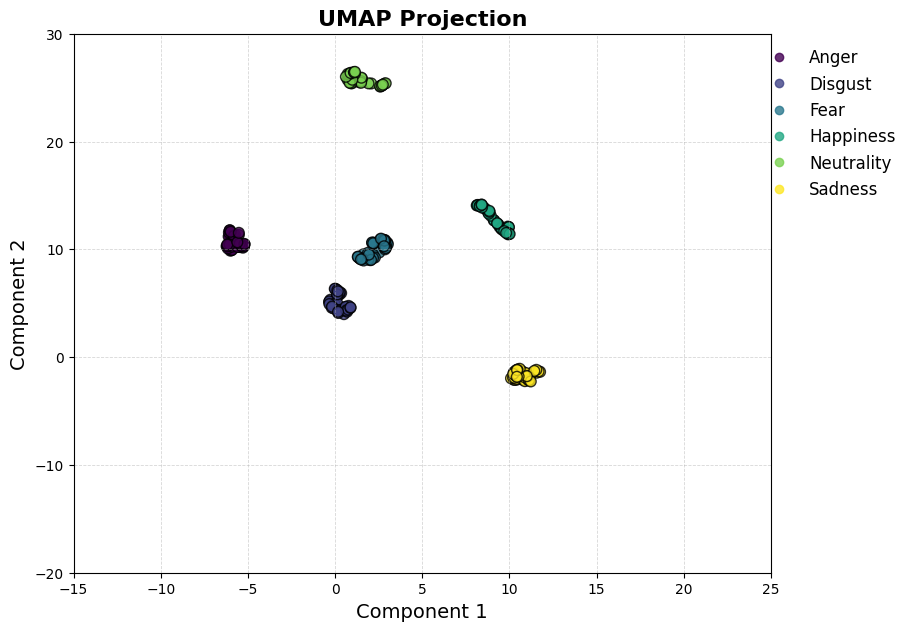

In [ ]:
without_parsimony(all_cremaD, cremaD_y, 'all_CremaD')

In [ ]:
parsymony_Umap(all_cremaD, cremaD_y, all_cremaD_names, custom_eval_fun, 0.01, 100, f"")

Running iteration 0
Best model -> Score = 615.286057 Complexity = 363.0 
Iter = 0 -> MeanVal = 580.722186  ValBest = 615.286057  ComplexBest = 363.0 Time(min) = 0.218967

Running iteration 1
Best model -> Score = 615.286057 Complexity = 363.0 
Iter = 1 -> MeanVal = 586.282678  ValBest = 614.620667  ComplexBest = 332.0 Time(min) = 0.137945

Running iteration 2
Best model -> Score = 617.088211 Complexity = 254.0 
Iter = 2 -> MeanVal = 575.594853  ValBest = 617.088211  ComplexBest = 254.0 Time(min) = 0.134556

Running iteration 3
Best model -> Score = 637.92218 Complexity = 235.0 
Iter = 3 -> MeanVal = 590.259264  ValBest = 637.92218   ComplexBest = 235.0 Time(min) = 0.14474

Running iteration 4
Best model -> Score = 640.97139 Complexity = 203.0 
Iter = 4 -> MeanVal = 598.520241  ValBest = 640.97139   ComplexBest = 203.0 Time(min) = 0.123204

Running iteration 5
Best model -> Score = 640.97139 Complexity = 203.0 
Iter = 5 -> MeanVal = 596.100448  ValBest = 626.051712  ComplexBest = 153.0 

#RAVDESS

In [ ]:
y_Ravedess = np.load('/content/drive/MyDrive/Data/Ravedess/y.npy')
all_Ravedess = np.load('/content/drive/MyDrive/Data/Ravedess/ALL.npy')
all_Ravedess_names = np.load('/content/drive/MyDrive/Data/Ravedess/all_names.npy')

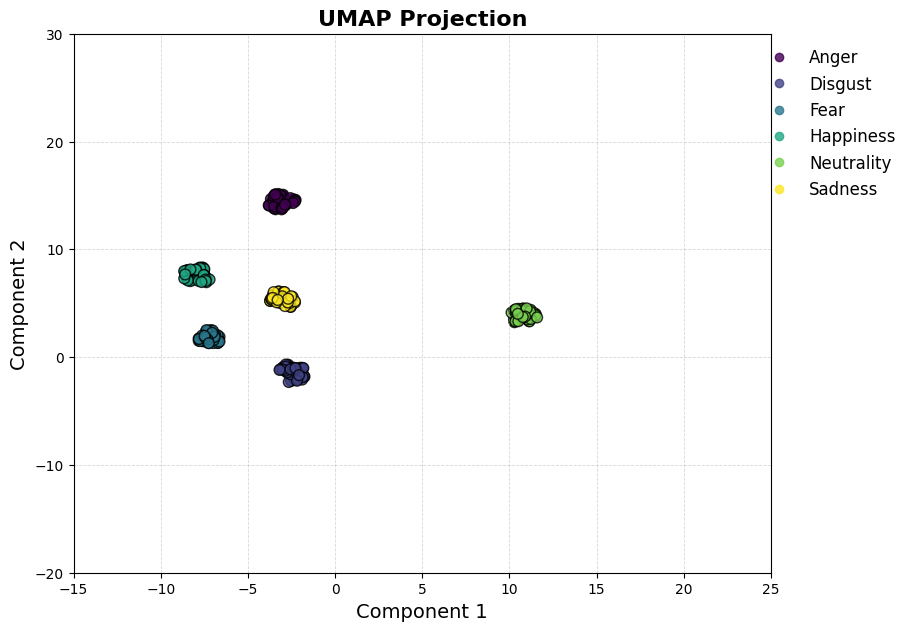

In [ ]:
without_parsimony(all_Ravedess, y_Ravedess, 'all_ravdess')

In [ ]:
parsymony_Umap(all_Ravedess, y_Ravedess, all_Ravedess_names, custom_eval_fun, 0.01, 100, f"")

Running iteration 0
Best model -> Score = 625.402191 Complexity = 376.0 
Iter = 0 -> MeanVal = 599.87845  ValBest = 625.402191  ComplexBest = 376.0 Time(min) = 0.129422

Running iteration 1
Best model -> Score = 638.588898 Complexity = 322.0 
Iter = 1 -> MeanVal = 604.716702  ValBest = 638.588898  ComplexBest = 322.0 Time(min) = 0.146014

Running iteration 2
Best model -> Score = 638.588898 Complexity = 322.0 
Iter = 2 -> MeanVal = 607.755777  ValBest = 635.318649  ComplexBest = 291.0 Time(min) = 0.118638

Running iteration 3
Best model -> Score = 660.016769 Complexity = 262.0 
Iter = 3 -> MeanVal = 614.347766  ValBest = 660.016769  ComplexBest = 262.0 Time(min) = 0.142244

Running iteration 4
Best model -> Score = 660.016769 Complexity = 262.0 
Iter = 4 -> MeanVal = 621.454553  ValBest = 645.539459  ComplexBest = 218.0 Time(min) = 0.12881

Running iteration 5
Best model -> Score = 660.016769 Complexity = 262.0 
Iter = 5 -> MeanVal = 615.748078  ValBest = 654.996887  ComplexBest = 207.